In [1]:
import numpy as np
import itertools
from copy import deepcopy
from scipy.stats  import multivariate_normal
import matplotlib 
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from IPython.core.debugger import set_trace
import random

In [32]:
# TODO: Just use a 3-tuple???
class cityLocation(object):
    def __init__(self,city="UNKNOWN",coords=None):
        self.city = city
        self.coords = coords

class cityAgent(object):
    
    def __init__(self, wealth=0,netTrade=0,atHome=True, homeCity=None, location = None):
        
        '''
        Inputs:
        
        income: float of income
        
        '''
        
        self.wealth = wealth
        self.homeCity=homeCity
        self.location=location
        self.netTrade = netTrade
        self.atHome=atHome
        
    def buyFrom(self, sellingAgent,gamma,delta):
        self.wealth = self.wealth*(1+delta)
        exchangeAmt = gamma*self.wealth
        self.wealth -= exchangeAmt
        sellingAgent.gainWealth(exchangeAmt)
        
    def gainWealth(self,amount):
        self.wealth += amount
        # can move this into city class
        self.netTrade += amount
        
class Stochastic_Schelling(object):

    def __init__(self, nCities=2,populations=[600,400],pMax=0.3):
        
        
        self.cities = []
        self.pMax = pMax
        self.populations=populations
        self.nCities = nCities
        self.cityNameOptions = ["Ciudad de Eli", "Gabopolis","Santa David","Drilandia","New Naomi","Slaughterville"]
        self.initCities()
        
        '''
        Inputs:
        
        grid_size: tuple (int, int). Size of the "population". Default (20, 20) 
        empty_percentage: float. Percent of cells that are empty. Default (0.3)
        threshold: float. Similarity threshold. Default: 0.7
        sim_range = float. Range in which the cell will consider "similar" income. Default 0.2
        mu= float. Mean for income log normal distribution. Default: 3.8
        sigma= float. Standard deviation for income log normal distribution. Default: 0.4
        delta= float. the number by which wealth is increased for the top 10% of income levels
        gamma= float. the multiplicative factor determing exchange of wealth
        interactionP =float. the probability of interacting with a neighbor
        moore: whether to consider a Moore neighborhood. Default: False (Von Neumann neighborhood)
        
        
        '''
        
    def initCities(self):
        
        pNorm = self.pMax/(np.max(self.populations)**0.15)
        
        citiesMapping = {}
        
        if isinstance(self.populations,list):
            if self.nCities != len(self.populations):
                raise Exception("nCities not equal to population list length")
            for _,pop in zip(range(self.nCities),self.populations):
                interactionP = pNorm*pop**0.15
                newCity = City(name=self.chooseName(),population=pop,interactionP=interactionP)
                self.cities.append(newCity)
                citiesMapping[newCity.name] = newCity
        
        for city in self.cities:
            city.updateOtherCitiesRefs(citiesMapping)
        
        
        #elif populations="Zipf": TODO
        
        
    def chooseName(self):
        return self.cityNameOptions.pop(random.randrange(len(self.cityNameOptions)))
        
        
    def display(self):
        for city in self.cities:
            city.display()
        
    # TODO: Optimization work needed. Does it work to match median wealths to an agent's wealth vs. comparing with each one?f
    def move_agents(self,nMove):
        
        
        
        ### Get Movers and probabilities of moving cross-city to a given city, proportional to city wealth
        
        allWealths = {}
        # get wealths for all cities to calculate top percents of agents in each city
        for city in self.cities:
            city.getWealths()
            allWealths[city] = city.wealthList
        sumWealthDict = {}
        sumAllWealth = 0
        for city,wealthList in allWealths.items():
            sumCity = np.sum(wealthList)
            sumWealthDict[city] = sumCity
            sumAllWealth += sumCity
        
        cityProbs = {}
        
        # NOTE: This is a naive assumption, and 
        for city in self.cities:
            # # uniform
            # cityProbs[city] = 1/len(self.cities)
            # proportional to total wealth in city
            cityProbs[city] = sumWealthDict[city]/sumAllWealth
        
        
        # agents to be moved into ANY city
        intlMovers = []
        # agents to moved within ONE city (mapping city to list of people moving within that city)
        movers = {}
        
        for city in self.cities:
            movers[city] = []
        
        #we find the most unsatisfied cells
        for city in self.cities:
            
            # find unsatisifed agents
            city.is_satisfied()
            
            nMovers = 0
#
            sqSatisfiedVals = list(map(lambda x: x**2, list(city.unsatisfied_cells.values())))
            
            for k, v in sorted(city.unsatisfied_cells.items(),key=lambda x: x[1]): 
                
                
                if nMovers >= nMove:
                    break
                    
                
                ca = city.cityAgents[k[0]][k[1]]
                if not (k == ca.location.coords and city.name == ca.location.city):
                    print(ca.location.city,ca.location.coords,k)
                    set_trace()
                
                
                # send people back to their home city if they're visiting
                if v == -1:
                    # move out of current before sending home NOTE: Might be cleaner to do this with ALL agents at this step, for myself
                    
                    movers[ca.homeCity].append(ca)
                    continue
                else:
                    nMovers += 1
                
                # TODO: See note in aboveWealthCutoff func: Should be same wealth (not percentage) cutoff across cities
                if city.aboveWealthCutoff(ca,0.1):
                    intlMovers.append(ca)
                else:
                    movers[city].append(ca)
                        
        for intlMover in intlMovers:
            # NOTE: Can change 1 for city agent to consider other cities, would need to implement below also
            moveTo = np.random.choice(list(cityProbs.keys()),1,p=list(cityProbs.values()))
            moveTo = moveTo[0]
            movers[moveTo].append(intlMover)
                                           
        for city,agentList in movers.items():
            
            #oldLocs = {}
            #for agent in agentList:
            #    oldLocs[agent] = agent.location
            city.move_agents(agentList)
            #update neighbour counts of the new empty space 
            #for agent in agentList:

        ## maps cities to list of tuples containing an agent within that city to be moved, and 
        ## True or False for whether or not their movement is able to consider all cities or just their own
        ## e.g. Boston -> [(Sarah,True),(Eli,True),(Aram,False)]
        #movers = {}
        ##we find the most unsatisfied cells
        #for city in self.cities:
        #    # find unsatisifed agents
        #    city.is_satisfied()
#
        #    # we select one randomly  TODO: Here, grab n number to move
        #    min_sim = []
        #    for k, v in city.unsatisfied_cells.items(): 
        #        ca = city.cityAgents[k[0]][k[1]]
        #        if v == -1:
        #            movers[ca.city].append((ca,False))
        #        sqSatisfiedVals = list(map(lambda x: x**2, list(self.unsatisfied_cells.values())))
        #        if v == np.nanmin(sqSatisfiedVals): 
        #            min_sim.append(k)
        #            # TODO: See note in aboveWealthCutoff func: Should be same wealth (not percentage) cutoff across cities
        #            if city.aboveWealthCutoff(ca,0.1):
        #                movers[city].append((ca,True))
        #            else:
        #                movers[city].append((ca,False))
        #    
        
        
    def interact(self):
        for city in self.cities:
            city.interact()
            
            
    def run_sim(self, nMoves=1,nInteractions=1,nMovers=6):
        for _ in range(nMoves):
            self.move_agents(nMovers)
        for _ in range(nInteractions):
            self.interact()
                
        
            

class City(object):

    def __init__(self, name=None,population=400, empty_percentage= 0.3, threshold = 0.7, sim_range = 0.2, mu= 3.8, sigma=0.4,gamma=0.05,delta=0.003,interactionP=0.25):
        '''
        Inputs:
        
        grid_size: tuple (int, int). Size of the "population". Default (20, 20) 
        empty_percentage: float. Percent of cells that are empty. Default (0.3)
        threshold: float. Similarity threshold. Default: 0.7
        sim_range = float. Range in which the cell will consider "similar" income. Default 0.2
        mu= float. Mean for income log normal distribution. Default: 3.8
        sigma= float. Standard deviation for income log normal distribution. Default: 0.4
        delta= float. the number by which wealth is increased (TODO: for the top 10% of income levels)
        gamma= float. the multiplicative factor determing exchange of wealth
        interactionP =float. the probability of interacting with a neighbor
        moore: whether to consider a Moore neighborhood. Default: False (Von Neumann neighborhood)
        
        '''
        self.grid_size = (int(round(np.sqrt(population))),int(round(np.sqrt(population))))
        self.population=population
        self.empty_percentage = empty_percentage
        self.sim_range= sim_range
        self.threshold = threshold
        self.mu= mu
        self.sigma = sigma
        self.delta=delta
        self.interactionP=interactionP
        self.gamma = gamma
        self.wealths = np.full(self.grid_size,None)
        self.wealthsList = []
        self.name=name
        self.otherCities = {}

        
        #variables
        self.cityAgents = np.full(self.grid_size,None) # array of cityAgents
        self.agentList = []
        self.neighbour_counts = {}
        self.neighbour_avg = {}
        self.unsatisfied_cells = {}
        
        #populate 
        self.populate(empty_percentage, self.grid_size, mu, sigma)
        
        #count empty cells 
        self.init_neighbour_counts()
        self.init_neighbour_avg()
        self.step = 0
    
        
        self.avg_income_system=[]
        self.density_system=[]
        self.min_income = []
        self.max_income = []
        
        
    def updateOtherCitiesRefs(self,otherCities):
        self.otherCities = otherCities
        
        
    # TODO: This should be the same WEALTH cutoff for all cities
    def aboveWealthCutoff(self,agent,cutOff):
        #Should already be sorted
        aWealth = agent.wealth
        i = 0
        for wealth in self.wealthList:
            if aWealth < wealth:
                break
            else:
                i += 1
        # percent of people in city who agent is richer than
        richerThan = i/len(self.wealthList)
        
        return (1-richerThan) < cutOff
        
        
        
        
        
    def getWealths(self):
        self.wealthList = []
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                agent = self.cityAgents[x][y]
                if agent:
                    self.wealths[x][y] = float(agent.wealth)
                    self.wealthList.append(agent.wealth)
                else:
                    self.wealths[x][y] = np.nan
        self.wealths = self.wealths.astype(float)
        self.wealthList.sort()
        return self.wealthList
            
        
    def populate(self, empty_percentage, grid_size, mu, sigma):
        '''
        Populate the grid.
        
        '''
        
        #if all the cells are empty, just return an empty grid
        if empty_percentage == 1:
            return 
        
        #populate the cells:
            #gaussian distribution for income
            #age start at 0
       
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                w = np.random.lognormal(self.mu, self.sigma, 1)
                self.cityAgents[x][y] = cityAgent(wealth=w[0],homeCity=self,location=cityLocation(city=self.name,coords=(x,y)))
                #we can modify for different distribution can be gaussian centered or skewed
        
        #given the empty cells percentage
        #we randomly empty some cells
       
        empty_grid = np.random.choice(range(grid_size[0]*grid_size[1]), round(empty_percentage * grid_size[0]* grid_size[1]), replace= False)
        

        #TODO: See if there's a more efficient way to do this within the previous loop
        for i in empty_grid:
            self.cityAgents[i % grid_size[0]][i // grid_size[0]] = None
       
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                if self.cityAgents[x][y]:
                    self.agentList.append(self.cityAgents[x][y])
    
    
    def display(self):
        '''
        Plot the state of the model.
        '''
        self.getWealths()
        plt.figure()
        plt.imshow(self.wealths)
        plt.colorbar()
        plt.title('[' + self.name+ '] Step: ' + str(self.step)+ ", Population = "+str(self.population) + ', Avg Wealth = ' + str(float("{0:.2f}".format(self.get_avg_val(self.cityAgents, self.grid_size)))))

    # TODO: Maybe move unsatisfied condition into agent class
    def is_satisfied(self, moore=False):
        '''
        We measured whether the cell is satisfied in its neighborhood. We get a the dict, 
        with a list of cells unsatified and their satisfaction ratio.

        '''
        self.unsatisfied_cells = dict()
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                agent = self.cityAgents[x][y]
                if agent:
                    
                    # Make not atHome cityAgents maximally unsatisified
                    if not agent.atHome:
                        if agent.homeCity.name == self.name:
                            set_trace()
                        self.unsatisfied_cells[(x,y)] = -1
                        continue
                    
                    similar = 0
                    different = 0
                    
                    if moore:
                        combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
                    else:
                        combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]

                    for i, j in combinations:
                        x_coordinate = (x + i) % self.grid_size[0]
                        y_coordinate = (y + j) % self.grid_size[1]

                        newAgent = self.cityAgents[x_coordinate][y_coordinate]
                        
                        if newAgent:
                            # OLD: if self.income[x][y]*-self.sim_range+self.income[x][y] <= self.income[x_coordinate][y_coordinate]<= self.income[x][y]+self.income[x][y]*self.sim_range:
                            # if neighbors are within +- simrange proportion of the center agents wealth, mark them as similar. Otherwise, they are different
                            if agent.wealth*-self.sim_range+agent.wealth <= newAgent.wealth <= agent.wealth+agent.wealth*self.sim_range:
                                similar +=1
                            else:
                                different +=1

                        # people always want to be around others
                        else:
                            different += 1
                    #if (similar + different) == 0: 
                    #    self.unsatisfied_cells[(x, y)] = 0.0
                        
                    if float(similar)/(similar+different) < self.threshold:
                        self.unsatisfied_cells[(x, y)] = (similar)/(similar+different)

                    
    
    def get_min_val(self, income):
        '''
        Return the minimum income value.
        
        '''
        
        return np.nanmin(self.income)
    
        
    def get_max_val(self, income):
        '''
        Return the maximum income value.
        
        '''
        
        return np.nanmax(self.income)
    
    def count_neighbours(self, x_spc, y_spc, moore=False):
        '''
        Return number of neighbours of a specific cell.
        
        '''
        neighbours= 0
        
        if moore:
            combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
        else:
            combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]
            
        for x, y in combinations:
            x_coordinate = (x_spc + x) % self.grid_size[0]
            y_coordinate = (y_spc + y) % self.grid_size[1]
            
            if self.cityAgents[x_coordinate][y_coordinate]:
                neighbours += 1
                
        return neighbours
    
    def avg_neighbors_wealth(self, x_spc, y_spc, moore=False):
        '''
        Return average wealth of the neighbours of a specific cell.
        
        '''
        neighbours = self.count_neighbours(x_spc, y_spc)
        if moore:
            combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
        else:
            combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]
            
        value=0
        for x, y in combinations:
            x_coordinate = (x_spc + x) % self.grid_size[0]
            y_coordinate = (y_spc + y) % self.grid_size[1]
            
            agent = self.cityAgents[x_coordinate][y_coordinate]
            
            if agent:
                value += agent.wealth
        
        if neighbours==0:
            return 0
        else:
            return value/neighbours
    
    def init_neighbour_avg(self):
        '''
        avg income of neighbors in each cell if empty 
        
        '''        
        
        #TODO: To optimize, have a variable giving all empty cells
        #we are having a dict with the avg of income of each empty cell
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                if not self.cityAgents[x][y]:
                    avg = self.avg_neighbors_wealth(x, y)
                    self.neighbour_avg[(x, y)] = avg
    
        
        
    def init_neighbour_counts(self):
        '''
        Counts the number of neighbors in each cell if empty 
        
        '''        
        
        #we are having a dict with the number of neighbors of each empty cell
        #for x in range(len(self.income)):
        #    for y in range(len(self.income[0])):
        #        if np.isnan(self.income[x][y]):
        #            count = self.count_neighbours(self.income, x, y)
        #            self.neighbour_counts[(x, y)] = count
        
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                # the boolean expression here will return true when the grid does not contain a city Agent
                if not self.cityAgents[x][y]:
                    count = self.count_neighbours(x, y)
                    self.neighbour_counts[(x, y)] = count
                    
                    
    def update_neighbour_avg(self, x_spc, y_spc, update_value, moore=False):
        '''
        Update neighbourhood counts given the new state. 
        New parameters:
            update_value: int. Change in the neighbour count.
            
        '''
        if moore:
            combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
        else:
            combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        
        if update_value <0:
            self.neighbour_avg[x_spc, y_spc]= self.avg_neighbors_wealth(x_spc, y_spc)
    
            
        else: 
            for x, y in combinations:
                x_coordinate = (x_spc + x)% self.grid_size[0]
                y_coordinate = (y_spc + y)% self.grid_size[1]

                agent = self.cityAgents[x_coordinate][y_coordinate]
                
                if not agent:
                    self.neighbour_avg[(x_coordinate, y_coordinate)] = self.avg_neighbors_wealth(x_coordinate, y_coordinate)

    
    def update_neighbour_counts(self, x_spc, y_spc, update_value, moore=False):
        '''
        
        New parameters:
            update_value: int. Change in the neighbour count.
            
        '''
        if moore:
            combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
        else:
            combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        
        if update_value <0:
            self.neighbour_counts[x_spc, y_spc]= self.count_neighbours(x_spc, y_spc)
            
        for x, y in combinations:
            x_coordinate = (x_spc + x)% self.grid_size[0]
            y_coordinate = (y_spc + y)% self.grid_size[1]
            
            agent = self.cityAgents[x_coordinate][y_coordinate]

            if not agent:
                self.neighbour_counts[(x_coordinate, y_coordinate)] = self.count_neighbours(x_coordinate, y_coordinate)
                
                
    def get_min_val_index(self):
        '''
        Returns the index of the minimum state value. (float)
        
        '''
        return np.argmin(self.income)
    
    
    def get_avg_val(self, cityAgents, grid_size):
        '''
        Returns the average of state value. (float)
        
        '''
        
        #make a list of non-null value of state values
        no_null = []
        for x in range(grid_size[0]):
            for y in range(grid_size[1]):
                cityAgent = cityAgents[x][y]
                if cityAgent:
                    no_null.append(cityAgent.wealth)
        
        if len(no_null)!=0:
            return np.mean(no_null)
        
        #if all cells are empty, return 0
        else:
            return 0
    
    
    def has_empty(self):
        '''
        Returns True if there is an empty cell. (Boolean)
        
        '''
        empty = np.where(np.isnan(self.income))
        
        if not empty[0].any():
            return False
        else:
            return True
        
        
    def get_density(self):
        '''
        Returns density of current state. (Float)
        If empty, then -1
        
        '''
        no_null_size = np.sum(not np.isnan(self.state))
        
        if no_null_size !=0:
            return no_null_size/(self.grid_size[0]*self.grid_size[1])
        return -1

    def move_agent(self,agent,newLoc):
        
        newCity = newLoc.city
        
        # NOTE: This should be unnecessary because we know we're moving to THIS city
        #newCityObj = self.otherCities[newCity]
        try:
            newCityObj = self.otherCities[newCity]
        except KeyError:
            set_trace()
        (x_new,y_new) = newLoc.coords
        
        oldLoc = agent.location
        (x_old,y_old) = oldLoc.coords
        oldCity= oldLoc.city
        #get object from name
        try:
            oldCityObj = self.otherCities[oldCity]
        except KeyError:
            set_trace()
        #move to new location
        newCityObj.cityAgents[x_new][y_new] = agent
        agent.location = newLoc
        
        #update the avg of the empty neighbours of the new occupied cell
        newCityObj.update_neighbour_counts(x_new, y_new, 1)
        newCityObj.update_neighbour_avg(x_new, y_new, 1)
        
    
        #remove from old location
        oldCityObj.cityAgents[x_old][y_old] = None
        oldCityObj.update_neighbour_counts(x_old, y_old, -1)
        oldCityObj.update_neighbour_avg(x_old, y_old, -1)
        
    
        #toMove = self.cityAgents[prev[0]][prev[1]]
        # if moving within city
        agent.atHome = (agent.homeCity.name == newCity)

        

        
            
    
    
    def move_agents(self,agents):
        '''
        Fills a cell with a higher fitting value. Update the states
        
        '''
        wealths = self.wealthList
        
        
        for agent in agents:
            
            mWealth = agent.wealth
      
            
        


            #list indexes of empty cells 
            empty_cells = list(self.neighbour_avg.keys())


            #neighborhood income avg for empty cell
            #neighbour_avg = self.neighbour_avg.values()
            neighbour_avg = np.array(list(self.neighbour_avg.values()))

            #probabilities of moving to empty cell, given avg income
            #without normalization- numerator:

            #neighbour_avg= (np.array(list(neighbour_avg))-mWealth)**2
            neighbour_avg = (neighbour_avg-mWealth)**2
            

            #probabilities with normalization (w/denominator):
    #         numerator = (neighbour_count - self.a * neighbour_avg)**2
            numerator = (np.nanmax(wealths)- neighbour_avg)**2
            probabilities = numerator / np.sum(numerator)
            probList = []
            probabilities = list(map(lambda x: float(x),list(np.reshape(probabilities,len(probabilities)))))
            for prob in probabilities:
                
                if not isinstance(prob,float):
                    print(prob)
                    set_trace()




            #choose an empty cell to fill given the probabilities
            
            choice = np.random.choice(list(range(len(probabilities))),1, p= probabilities)
            empty_choice= empty_cells[choice[0]]

            oldLoc = agent.location
            
            #remove the cell from empty list
            self.neighbour_counts.pop((empty_choice[0], empty_choice[1]), None)

            moveTo = cityLocation(city=self.name,coords=empty_choice)
            #NOTE: At this point, nothing in the agent or city should have changed
            self.move_agent(agent,moveTo)
     
        

        
        
        
    def interact(self,moore=False):
        
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                
                buyingAgent = self.cityAgents[x][y]
                
                if not buyingAgent:
                    continue

                if moore:
                    combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
                else:
                    combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]

                for x_n, y_n in combinations:

                    x_coordinate = (x + x_n)% self.grid_size[0]
                    y_coordinate = (y + y_n)% self.grid_size[1]
                    
                    sellingAgent = self.cityAgents[x_coordinate][y_coordinate]

                    # given probability of interacting, do interactions
                    if sellingAgent: 
                        if random.random() < self.interactionP:
                            buyingAgent.buyFrom(sellingAgent,self.gamma,self.delta)
                        
                        if random.random() < self.interactionP:
                            sellingAgent.buyFrom(buyingAgent,self.gamma,self.delta)
        
        # TODO: These functions
        #self.avg_income_system.append(self.get_avg_val())
        #self.min_income.append(self.get_min_val())
        #self.max_income.append(self.get_max_val())
        
        
        self.step += 1

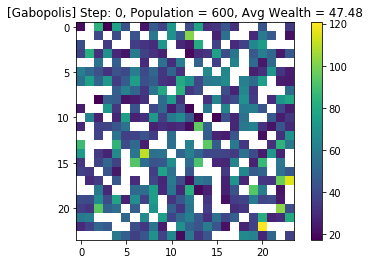

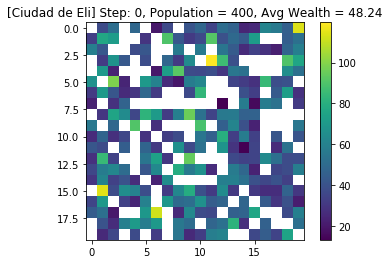

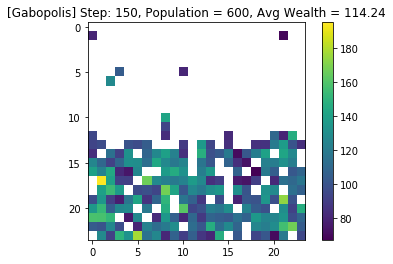

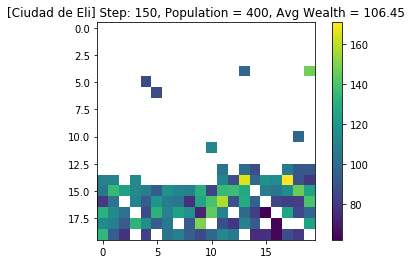

In [34]:
sim = Stochastic_Schelling()
# TODO: 
sim.display()
for _ in range(150):
    sim.run_sim()
sim.display()


In [ ]:
sim = Stochastic_Schelling()
for _ in range(10):
    sim.move_cell()
    sim.update_grid()
    
sim.display()


plt.show()

In [ ]:
mu, sigma = 3.8, 0.4 # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)


import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
        / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

In [ ]:
plt.plot(range(sim.step), sim.min_income, label='Min Income')
plt.plot(range(sim.step), sim.max_income, label='Max Income')
plt.plot(range(sim.step), sim.avg_income_system, label='Avg')

plt.ylabel('Income')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [ ]:
sims = [Stochastic_Schelling(threshold= 0.3),
        Stochastic_Schelling(threshold= 0.5),
        Stochastic_Schelling(threshold= 0.7),
        Stochastic_Schelling(threshold= 0.9)]


for sim in sims:
    for _ in range(10):
        sim.move_cell()
        sim.update_grid()
    plt.plot(range(sim.step),sim.min_income, label = 'Threshold = {}'.format(sim.threshold))

plt.legend(fontsize=8, loc=4)
plt.xlabel('Timestep')
plt.ylabel('Income')
plt.show()


In [ ]:
sims = [Stochastic_Schelling(threshold= 0.3),
        Stochastic_Schelling(threshold= 0.5),
        Stochastic_Schelling(threshold= 0.7),
        Stochastic_Schelling(threshold= 0.9)]


for sim in sims:
    for _ in range(10):
        sim.move_cell()
        sim.update_grid()
    plt.plot(range(sim.step),sim.max_income, label = 'Threshold = {}'.format(sim.threshold))

plt.legend(fontsize=8, loc=4)
plt.xlabel('Timestep')
plt.ylabel('Income')
plt.show()

In [ ]:
sims = [Stochastic_Schelling(threshold= 0.3),
        Stochastic_Schelling(threshold= 0.5),
        Stochastic_Schelling(threshold= 0.7),
        Stochastic_Schelling(threshold= 0.9)]


for sim in sims:
    for _ in range(10):
        sim.move_cell()
        sim.update_grid()
    plt.plot(range(sim.step),sim.avg_income_system, label = 'Threshold = {}'.format(sim.threshold))

plt.legend(fontsize=8, loc=4)
plt.xlabel('Timestep')
plt.ylabel('Income')
plt.show()